In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import dask.array as da
import numpy as np
import pandas as pd
import plotly.express as px

from distributed import Client
from dask.array.routines import matmul_old, matmul
from dask.distributed import wait, progress
from dask.diagnostics import ResourceProfiler

In [3]:
from plotly import io as pio
pio.renderers.default = "png+plotly_mimetype"

In [4]:
def get_dask_cluster():
    # GIL shouln't be a problem in this pipeline, also old matmul runs
    # out of memory when there is more processes to split the memory
    return Client(processes=False)

In [5]:
c = get_dask_cluster()
c

Client Scheduler: inproc://192.168.1.242/8387/1 Dashboard: http://192.168.1.242:8787/status,Cluster Workers: 1 Cores: 8 Memory: 34.36 GB


In [6]:
def perf_test(matmul_fn):
    results = []
    for n in 10**np.array([3, 3.5, 4, 4.5, 5, 5.5, 6]):
        chunks = (1000, 250)
        m = 1000
        n = int(n)
        with ResourceProfiler() as prof:
            X = da.random.random(size=(n, m), chunks=chunks)
            Y = da.random.random(size=(n, 3), chunks=(chunks[0], -1))
            R = matmul_fn(X.T, Y)
            R.max().compute()
        results.append((m, n, prof.results))

    return pd.DataFrame([
        dict(m=r[0], n=r[1], mem=e.mem)
        for r in results
        for e in r[2]
    ])

In [7]:
%%time
master_df = perf_test(matmul_old)

CPU times: user 39 s, sys: 8.67 s, total: 47.7 s
Wall time: 22.6 s


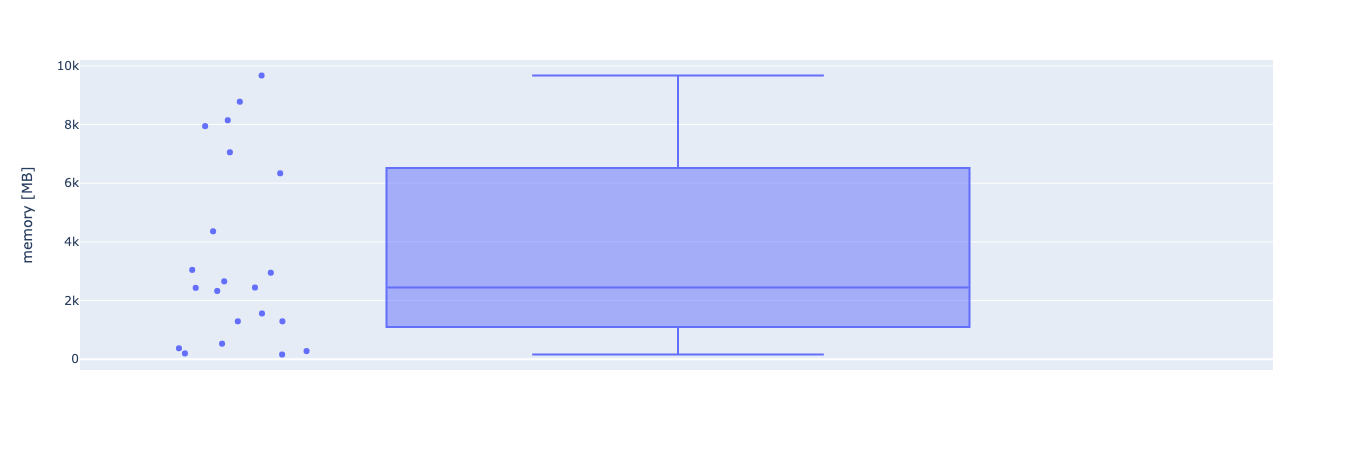

In [8]:
px.box(master_df, y="mem", points="all", labels={"mem": "memory [MB]"})

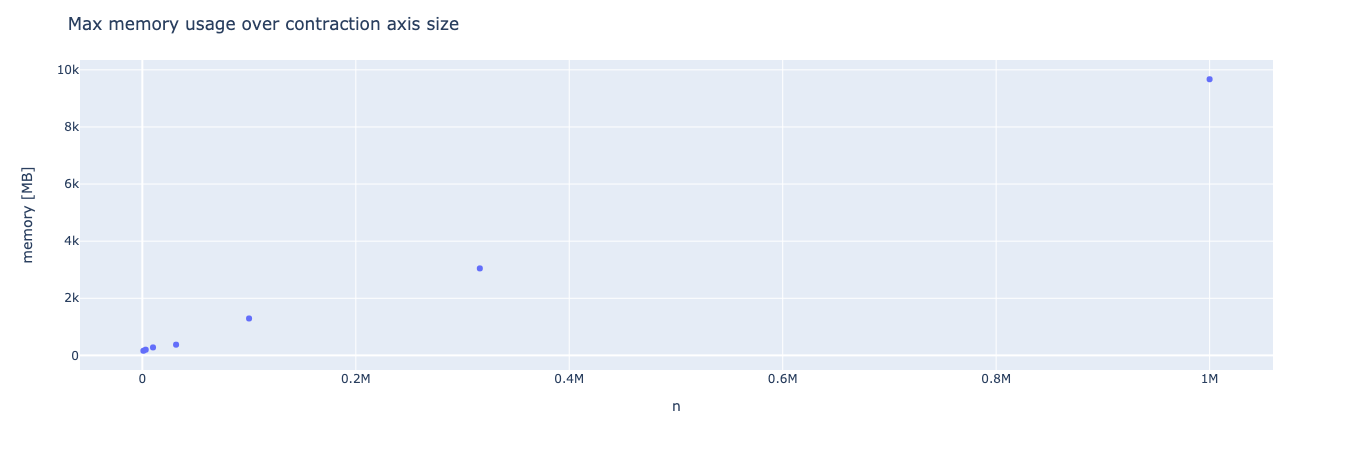

In [10]:
f = px.scatter(master_df.groupby(["n", "m"]).max().reset_index(drop=False),
               x="n", y="mem", labels={"mem": "memory [MB]"})
f.update_layout(title="Max memory usage over contraction axis size")

In [11]:
# Restart the dask cluster to start from clean state
c.close()
c = get_dask_cluster()
c

Client Scheduler: inproc://192.168.1.242/8387/10 Dashboard: http://192.168.1.242:8787/status,Cluster Workers: 1 Cores: 8 Memory: 34.36 GB


In [12]:
%%time
new_df = perf_test(matmul)

CPU times: user 1min 15s, sys: 13.3 s, total: 1min 28s
Wall time: 27.6 s


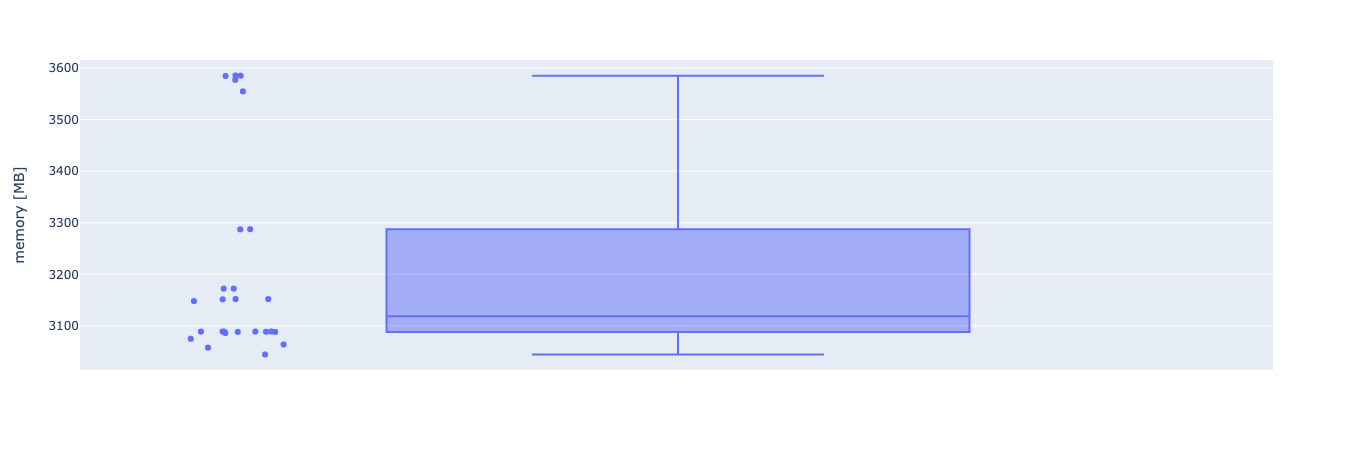

In [13]:
px.box(new_df, y="mem", points="all", labels={"mem": "memory [MB]"})

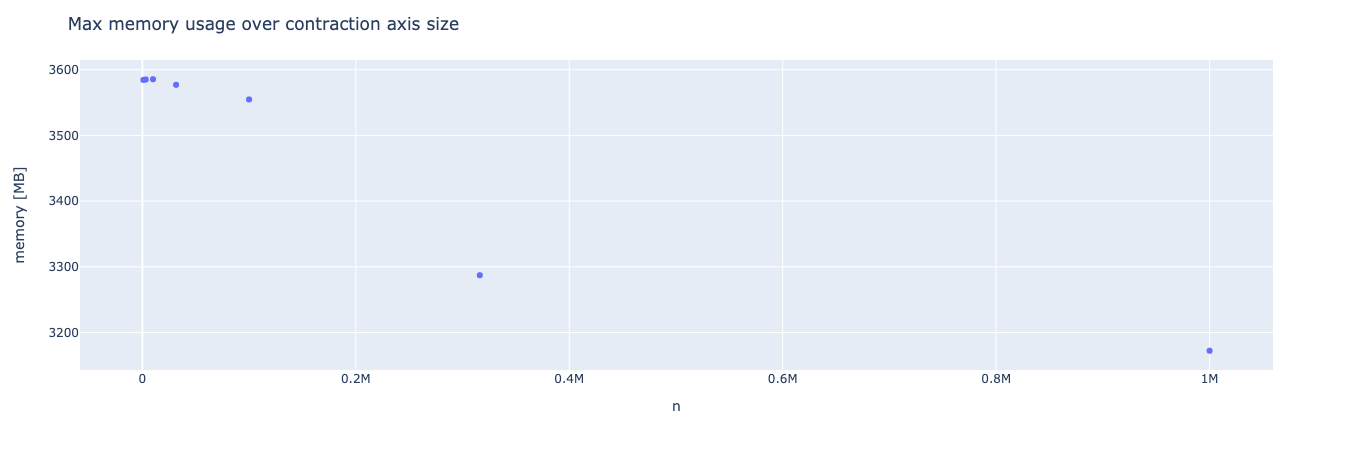

In [14]:
f = px.scatter(new_df.groupby(["n", "m"]).max().reset_index(drop=False),
               x="n", y="mem", labels={"mem": "memory [MB]"})
f.update_layout(title="Max memory usage over contraction axis size")